<a href="https://colab.research.google.com/github/sampadagawde/creditcard/blob/main/CreditCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CREDIT CARD FRAUD DETECTION PIPELINE

[1] Dataset Loaded Successfully
    Shape: (50, 31)
    Columns: ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class']

    Fraud Distribution:
Class
0.0    32
1.0     3
Name: count, dtype: int64
    Fraud Percentage: 8.57%

[2] DATA PREPROCESSING
    Missing values (after dropping NaNs in 'Class'): 0
    ✓ Features scaled using StandardScaler

[3] ANOMALY DETECTION (Isolation Forest)
    ✓ Anomaly scores generated
    ✓ Detected anomalies: 1

[4] CLASS BALANCING (SMOTE)
    Original distribution: {0.0: 32, 1.0: 3}
    Balanced distribution: {0.0: 32, 1.0: 32}
    ✓ Dataset balanced successfully

[5] TRAIN-TEST SPLIT
    Training set: (51, 31)
    Testing set: (13, 31)

[6] MODEL TRAINING

    Training Logistic Regression...
    ✓ Logistic Regression trained
    Training Gradient Boosting C

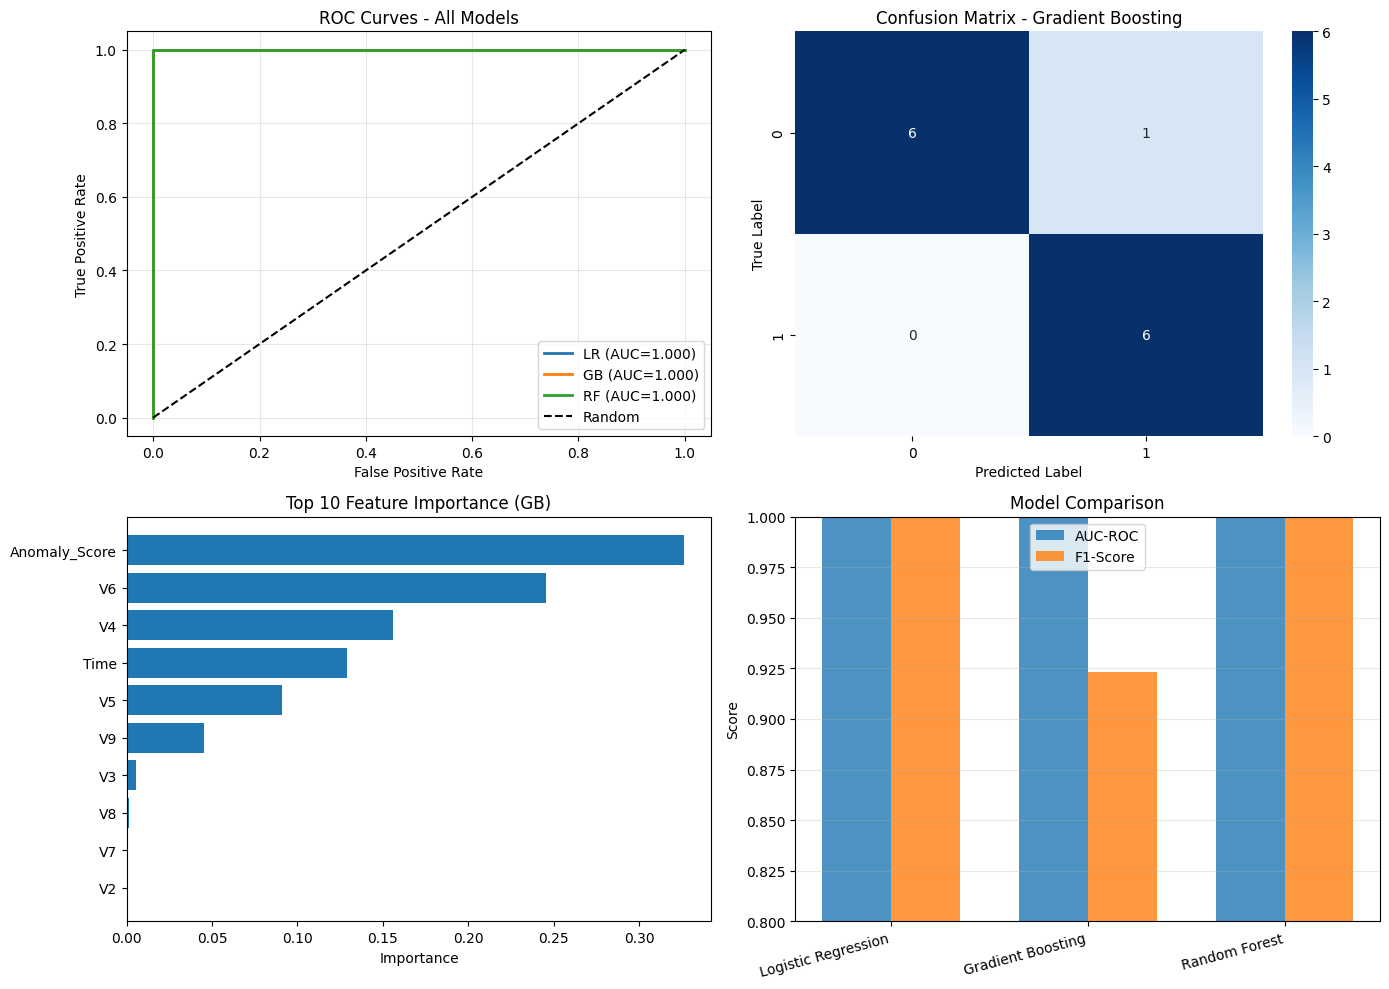

In [3]:
# Credit Card Fraud Detection with Advanced Pipeline
# Handles Imbalanced Data with Isolation Forest + SMOTE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# ==================== STAGE 1: DATA LOADING & EXPLORATION ====================
print("=" * 70)
print("CREDIT CARD FRAUD DETECTION PIPELINE")
print("=" * 70)

# Load dataset
df = pd.read_csv('credit_card_data.csv')
print("\n[1] Dataset Loaded Successfully")
print(f"    Shape: {df.shape}")
print(f"    Columns: {df.columns.tolist()}")
print(f"\n    Fraud Distribution:\n{df['Class'].value_counts()}")
print(f"    Fraud Percentage: {df['Class'].mean()*100:.2f}%")

# ==================== STAGE 2: PREPROCESSING ====================
print("\n" + "=" * 70)
print("[2] DATA PREPROCESSING")
print("=" * 70)

# Handle missing values - Ensure no NaNs in 'Class' column
df.dropna(subset=['Class'], inplace=True)
print(f"    Missing values (after dropping NaNs in 'Class'): {df.isnull().sum().sum()}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print(f"    ✓ Features scaled using StandardScaler")

# ==================== STAGE 3: UNIQUE FEATURE - ISOLATION FOREST ====================
print("\n" + "=" * 70)
print("[3] ANOMALY DETECTION (Isolation Forest)")
print("=" * 70)

iso_forest = IsolationForest(
    contamination=0.01,  # Expected fraud rate
    random_state=42,
    n_estimators=100
)
anomaly_labels = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.score_samples(X_scaled)

# Create anomaly feature
X_scaled['Anomaly_Score'] = anomaly_scores
print(f"    ✓ Anomaly scores generated")
print(f"    ✓ Detected anomalies: {(anomaly_labels == -1).sum()}")

# ==================== STAGE 4: CLASS BALANCING WITH SMOTE ====================
print("\n" + "=" * 70)
print("[4] CLASS BALANCING (SMOTE)")
print("=" * 70)

smote = SMOTE(random_state=42, k_neighbors=2) # Changed k_neighbors from 5 to 2
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

print(f"    Original distribution: {y.value_counts().to_dict()}")
print(f"    Balanced distribution: {pd.Series(y_balanced).value_counts().to_dict()}")
print(f"    ✓ Dataset balanced successfully")

# ==================== STAGE 5: TRAIN-TEST SPLIT ====================
print("\n" + "=" * 70)
print("[5] TRAIN-TEST SPLIT")
print("=" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"    Training set: {X_train.shape}")
print(f"    Testing set: {X_test.shape}")

# ==================== STAGE 6: MODEL TRAINING ====================
print("\n" + "=" * 70)
print("[6] MODEL TRAINING")
print("=" * 70)

# Model 1: Logistic Regression
print("\n    Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)
print("    ✓ Logistic Regression trained")

# Model 2: Gradient Boosting Classifier
print("    Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)
print("    ✓ Gradient Boosting trained")

# Model 3: Random Forest
print("    Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("    ✓ Random Forest trained")

# ==================== STAGE 7: MODEL EVALUATION ====================
print("\n" + "=" * 70)
print("[7] MODEL EVALUATION")
print("=" * 70)

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"\n    {model_name}:")
    print(f"      AUC-ROC: {auc_score:.4f}")
    print(f"      F1-Score: {f1:.4f}")
    print(f"      Classification Report:")
    print(f"      {classification_report(y_test, y_pred, digits=4)}")

    return auc_score, f1, y_pred, y_pred_proba

# Evaluate all models
lr_auc, lr_f1, lr_pred, lr_proba = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
gb_auc, gb_f1, gb_pred, gb_proba = evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")
rf_auc, rf_f1, rf_pred, rf_proba = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# ==================== STAGE 8: CROSS-VALIDATION ====================
print("\n" + "=" * 70)
print("[8] CROSS-VALIDATION (5-Fold Stratified)")
print("=" * 70)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, name in [(lr_model, "LR"), (gb_model, "GB"), (rf_model, "RF")]:
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    print(f"    {name} - F1 Scores: {cv_scores} | Mean: {cv_scores.mean():.4f}")

# ==================== STAGE 9: FEATURE IMPORTANCE ====================
print("\n" + "=" * 70)
print("[9] FEATURE IMPORTANCE (Top 10)")
print("=" * 70)

# Gradient Boosting Feature Importance
gb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n    Gradient Boosting Top Features:")
print(gb_importance.head(10).to_string(index=False))

# ==================== STAGE 10: VISUALIZATION ====================
print("\n" + "=" * 70)
print("[10] GENERATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

axes[0, 0].plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_auc:.3f})', linewidth=2)
axes[0, 0].plot(fpr_gb, tpr_gb, label=f'GB (AUC={gb_auc:.3f})', linewidth=2)
axes[0, 0].plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_auc:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves - All Models')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Confusion Matrices
cm_gb = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Gradient Boosting')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# Feature Importance
top_10_features = gb_importance.head(10)
axes[1, 0].barh(range(len(top_10_features)), top_10_features['Importance'].values)
axes[1, 0].set_yticks(range(len(top_10_features)))
axes[1, 0].set_yticklabels(top_10_features['Feature'].values)
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 10 Feature Importance (GB)')
axes[1, 0].invert_yaxis()

# Model Comparison
models = ['Logistic Regression', 'Gradient Boosting', 'Random Forest']
auc_scores = [lr_auc, gb_auc, rf_auc]
f1_scores = [lr_f1, gb_f1, rf_f1]

x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, auc_scores, width, label='AUC-ROC', alpha=0.8)
axes[1, 1].bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim([0.8, 1.0])
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
print("    ✓ Visualizations saved as 'fraud_detection_results.png'")

# ==================== STAGE 11: SUMMARY REPORT ====================
print("\n" + "=" * 70)
print("[11] FINAL SUMMARY")
print("=" * 70)

summary_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest'],
    'AUC-ROC': [lr_auc, gb_auc, rf_auc],
    'F1-Score': [lr_f1, gb_f1, rf_f1]
})

print("\n" + summary_df.to_string(index=False))

best_model_idx = summary_df['AUC-ROC'].idxmax()
best_model_name = summary_df.loc[best_model_idx, 'Model']
print(f"\n    🏆 Best Model: {best_model_name}")
print(f"       AUC-ROC: {summary_df.loc[best_model_idx, 'AUC-ROC']:.4f}")
print(f"       F1-Score: {summary_df.loc[best_model_idx, 'F1-Score']:.4f}")

# Save results to CSV
summary_df.to_csv('model_performance_results.csv', index=False)
print("\n    ✓ Results saved to 'model_performance_results.csv'")

print("\n" + "=" * 70)
print("PIPELINE EXECUTION COMPLETED ✓")
print("=" * 70)